# Lab 9b – Custom Dataset & Transfer Learning

## Part A. MS Cats and Dogs
- Ensure that you **enable GPU** and work on Part A in one go to save time
- Download the zip file from this website to your local machine https://www.microsoft.com/en-us/download/details.aspx?id=54765
- Click on the red "Download" button to download it to your computer.

### Save Zip to Drive and Mount Drive
- Upload the zip file `kagglecatsanddogs_3367a.zip` onto a folder called "DL" in your Drive (might take a few minutes)
- You can name the folder anything you want but replace "DL" with that folder in the code cells below
- You will be asked for an authorisation code. Follow the link, sign in and copy the code
- You should see "gdrive" folder on the left pane



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Inspect the folder where the zip file is
- Replace `DL` with your own folder or remove it from that path if it is in your main Drive folder

In [ ]:
!ls '/content/gdrive/MyDrive/data/'

피셋방세     FashionMNIST	   kagglecatsanddogs_3367a.zip
FashinMNIST  hymenoptera_data.zip  MNIST


### Copy it to your current directory
- When this code cell finishes, refresh the folder on the left pane and you should see the zip file in it

In [ ]:
!cp '/content/gdrive/MyDrive/data/kagglecatsanddogs_3367a.zip'

### Unzip the zip file
- You should now see `PetImages` folder with `Cat` and `Dog` folders inside
- You may want to close the cell code output after it is done

In [ ]:
!unzip kagglecatsanddogs_3367a.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: P

In [ ]:
import glob # Unix style pathname pattern matching
import cv2 # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader


### Pre-processing: Organise Images Contained in Folders
- Normally training and test data are organised in SEPARATE directories so you can easily just call the constructor class on these separate folders
- However, we only have two folders containing **ALL images** of cats and dogs respectively and there are **NO labels** provided. The folder name is the indication of the class label.
- Often you might also work with **annotation files** that give textual references to which might be slightly easier to work with
- Here, we will go through all the image files contained in `PetImages` (and its subdirectories) and for each of them, store their path and class label in a list called **`init_data`**
- We will use *glob* and *OpenCV* to do these
- We will do the data splitting into train set and test set later

In [ ]:
root_dir = "PetImages/"
file_list = glob.glob(root_dir + "*")

In [ ]:
file_list

['PetImages/Dog', 'PetImages/Cat']

In [ ]:
root_dir = "PetImages/"

# Retrieve the list of ALL folders and files inside the base folder
file_list = glob.glob(root_dir + "*") # ['PetImages/Dog', 'PetImages/Cat']

init_data = []
# Create a list that would contain the paths to all the images in the dataset
# 모든 img의 path를 포함한 리스트 생성하기
for class_path in file_list:

    # "/" 기준으로 split한 후 맨 뒤 (=Dog | Cat)의 이름 빼내기 => 이게 우리가 분류할 대상인 class 이름이 됨
    class_name = class_path.split("/")[-1] # extract the class name, e.g. 'PetImages/Dog' --> 'Dog'
    
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    
    # glob에서 *는 모든 것을 뜻하고, .jpg 형식을 갖는 모든 파일의 이름을 list로 생성한 후
    # for 문을 통해 iterative하게 개별 이미지의 path를 읽는 과정
    for img_path in glob.glob(class_path + "/*.jpg"): # for each file with the extension ".jpg"
        

        # cv2.imread(path, method for reading image;flag)
        # cv2.IMREAD_COLOR => color img type (default)
        # cv2.IMREAD_GRAYSCALE => gray img type
        # cv2.IMREAD_UNCHANGED => original
        # 이미지 파일을 읽기 위한 object를 return해줌 
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)               
        
        # Check for problematic images  
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue

        # 사용할 데이터의 경로와 클래스 이름이 pair로 init_data 내에 저장됨

        init_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(init_data) # [['PetImages/Dog/4.jpg', 'Dog'], ...]  
print(len(init_data))

# Q1. Given that there are a total of 25,000 images in the folders, did all the images get saved into init_data? 
# Explain why do you think not all images were loaded if that was the case.

# 24964 images are saved in 'init_data'.
# There might be some images that have size 0 or non-existence('None')

[['PetImages/Dog/2042.jpg', 'Dog'], ['PetImages/Dog/5438.jpg', 'Dog'], ['PetImages/Dog/10883.jpg', 'Dog'], ['PetImages/Dog/6378.jpg', 'Dog'], ['PetImages/Dog/12393.jpg', 'Dog'], ['PetImages/Dog/2403.jpg', 'Dog'], ['PetImages/Dog/9247.jpg', 'Dog'], ['PetImages/Dog/1787.jpg', 'Dog'], ['PetImages/Dog/1170.jpg', 'Dog'], ['PetImages/Dog/4322.jpg', 'Dog'], ['PetImages/Dog/6318.jpg', 'Dog'], ['PetImages/Dog/9839.jpg', 'Dog'], ['PetImages/Dog/7563.jpg', 'Dog'], ['PetImages/Dog/7905.jpg', 'Dog'], ['PetImages/Dog/7039.jpg', 'Dog'], ['PetImages/Dog/7584.jpg', 'Dog'], ['PetImages/Dog/3043.jpg', 'Dog'], ['PetImages/Dog/3513.jpg', 'Dog'], ['PetImages/Dog/8866.jpg', 'Dog'], ['PetImages/Dog/4311.jpg', 'Dog'], ['PetImages/Dog/1060.jpg', 'Dog'], ['PetImages/Dog/10708.jpg', 'Dog'], ['PetImages/Dog/4700.jpg', 'Dog'], ['PetImages/Dog/10670.jpg', 'Dog'], ['PetImages/Dog/2732.jpg', 'Dog'], ['PetImages/Dog/9720.jpg', 'Dog'], ['PetImages/Dog/10241.jpg', 'Dog'], ['PetImages/Dog/6554.jpg', 'Dog'], ['PetImages/Do

### Display any one image

In [ ]:
init_data[0][0]

'PetImages/Dog/2042.jpg'

(428, 472)

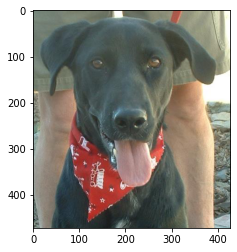

In [ ]:
# Display any image with known name
from PIL import Image

img = Image.open(init_data[0][0])
plt.imshow(img)  
img.size

### Device Configuration and Hyper-parameters

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper-parameters
SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
BATCH = 4
EPOCHS = 1
LR = 0.001

cuda


### Create a Custom Dataset
- This class contains three main methods `__init__()`, `__len__()` and `__getitem__()`
- All three should be implemented although `__init__()` is not mandatory

In [ ]:
p,c = init_data[0]

In [ ]:
print(p)
print(c)

PetImages/Dog/2042.jpg
Dog


In [ ]:
# 보기 좋게 데이터가 가공되어 있는 형태도 있지만, 아닌 경우가 더 많음
# Cat Dog 데이터는 아닌 경우 (그저 jpg)이기 때문에 변환하는 과정이 필요하고,
# 그걸 Dataset class를 overriding 해서 클래스를 지정함
# 이때 __init__, __len__, __getitem__ method를 필수로 지정해주어야함
# __getitem__ method 에서는
# 1) 입력된 이미지를 읽고, 2) 각 이미지에 클래스를 할당하고, 3) 이미지를 resize하고 4) transform하고 5) tensor로 변환하는 과정이 들어감
class CustomCatDog(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"Dog" : 0, "Cat": 1} 
        # Set image dimensions
        self.img_dim = (SIZE, SIZE) 
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):

        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()

        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, self.img_dim) # 미리 저장한 SIZE 값으로 resizing

        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id) 

        return img_tensor, class_id

### Transforms
- Training set and test set have slightly different transforms

In [ ]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(SIZE, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])

# Q2. Why is resizing not done in transforms?
# Since resizing will be done by 'cv2.resize()' before transforms, there is no resizing code in transforms

# Q3. Think of ONE more transform that could be applied on the train set. You DO NOT have to implement it.
# For example, transforms.ColorJitter()

### Split Dataset into Training & Test Sets and Load

In [ ]:
# Divide dataset into training and test sets using 80/20 ratio
train_size = int(0.8 * len(init_data))
test_size = len(init_data) - train_size

# train test split with 8:2
train_set, test_set = torch.utils.data.random_split(init_data, [train_size, test_size])

# make train dataset 
trainset = CustomCatDog(train_set, transform=train_transforms)
print(len(trainset))
# make test dataset
testset = CustomCatDog(test_set, transform=test_transforms)
print(len(testset))

# CustomCatDog 클래스를 통해 DataLoader가 받을 수 있는 형태로 변환했으니 minibatch로 분리
train_loader = DataLoader(trainset, batch_size=BATCH,
                          shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH,
                          shuffle=False, num_workers=2, pin_memory=True)

# num_workers : data load multi-processing의 수를 정함 = multi-core processing
# In some cases, it is considered as hyperparameter to be tuned.
# pin_memory : True면, tensor를 cuda 고정 메모리에 올린다.


# Q4. What is the effect of splitting the data randomly and shuffling the data when loading?
# It prevents from overfitting. By doing this, model will be robust

19956
4990


### Visualisation

torch.Size([4, 3, 224, 224])
class labels: tensor([1, 1, 1, 0])


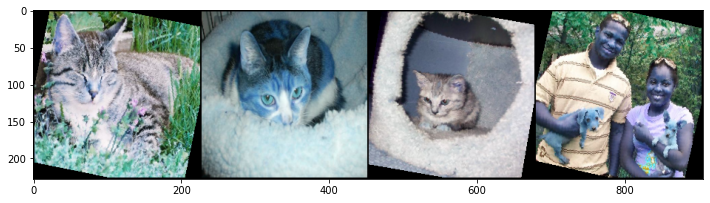

In [ ]:
# A function to denormalise an image for better visualisation
def inverse_normalize(tensor, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean) # inverse nomarlization
    return tensor

# Get a batch of images from the train loader
batch = next(iter(train_loader))

# 첫번째 배치 (with shuffled)
images, labels = batch

print(images.shape)

images = inverse_normalize(tensor=images, mean=MEAN, std=STD)  

# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

# Q5. What are the values passed into inverse_normalize() for mean and std in this code cell?
# They were used to normalize the orignial image in transforms.Normalize()

# Q6. Where are these displayed images stored?
# They are stored in train_loader from trainset.

### Load a Pre-trained Model

In [ ]:
from torchvision import models

# VGG16 Model Loading
use_pretrained = True
model = models.vgg16(pretrained=use_pretrained)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Q7. Why does the final output layer of VGG16 contain 1000 units?
# B/c the model was made for classification 1000 classes originally.

### Get final layer name

In [ ]:
# Run this code cell to see all the names of the layers
for n, m in model.named_modules():
     m.auto_name = n
     print(n)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


### Make modifications to the Final Output Layer Only

In [ ]:
# pre-trained 모델을 사용할 때에는 우리 데이터에 맞게 적절히 변형해야 함 아래처럼
# Change the Last Layer, classifier[6]
# Output Features 1000 -> 2
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
print('Done')

# Q8. Why are there 2 units in the final output layer now? What type of task is the network trying to learn?
# We have 2 two classes to classify. Binary classification.

Done


### Specify Layers for Parameter Updates

In [ ]:
# Create list
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

# 마지막 layer에 대해서만 파라미터 변경
# 마지막 layer에 대해서만 파라미터 업데이트 함 (transfer learning)
for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False


classifier.6.weight
classifier.6.bias


In [ ]:
# Q9. How many layers will be retrained according to the code?
# Only one layer

# Q10. Which layers will be retrained?
# Last linear layer

### Loss and Optimiser

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Important! Place model on GPU BEFORE optimiser is initialised
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params_to_update, lr=0.0005)

# Q11. Looking at the loss function, what output activation function will this neural network have?
# Sigmoid

# Q12. Why is the first argument to the optimiser not model.parameters()?
# This is transfer learning.
# We need to update the params only for the last layer for binary classification.

### Training Loop
- Function `train()` takes in the NN model, `net`, the training data loader, `dataloader`, the test_loader, `val_dataloader`, optimiser and loss


In [ ]:
import time

n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // BATCH) # ceiling division
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

def test(net, dataloader):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total
    print(f'Val Accuracy: {acc:.2f}')
    net.train()
    return round(acc, 2)

def train(net, dataloader, test_dataloader, optimizer, criterion):
    since = time.time() # start time

    num_epochs = 1
    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            freq = 50
            if ((i+1) % freq) == 0:
                print(f'Epoch {epoch + 1} Iteration {i + 1}/{n_iterations} Train Loss: {(running_loss / freq):.4f}')
                running_acc = test(net, test_dataloader)
                if (running_acc >= 97.75): # stop when 97.75% accuracy is reached
                  break
                running_loss = 0.0

    time_elapsed = time.time() - since
    print(f'Finished Training {time_elapsed}')

Total steps: 19956
Iterations per epoch: 4989


### Call the Train Function

In [ ]:
train(model, train_loader, test_loader, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Iteration 50/4989 Train Loss: 0.2654
Val Accuracy: 96.65
Epoch 1 Iteration 100/4989 Train Loss: 0.1090
Val Accuracy: 97.15
Epoch 1 Iteration 150/4989 Train Loss: 0.1321
Val Accuracy: 97.45
Epoch 1 Iteration 200/4989 Train Loss: 0.0898
Val Accuracy: 97.49
Epoch 1 Iteration 250/4989 Train Loss: 0.1040
Val Accuracy: 97.39
Epoch 1 Iteration 300/4989 Train Loss: 0.1365
Val Accuracy: 97.45
Epoch 1 Iteration 350/4989 Train Loss: 0.1657
Val Accuracy: 97.76
Finished Training 932.9913058280945


In [ ]:
# Q13. What was the accuracy on the test set after the first 50 iterations?
# 96.95

# Q14. What explains the high accuracy after just the first 50 iterations?
# The pre-trained model(VGG16) was trained well and robust.

# Q15. Why is training still relatively slow using a small batch size of 4?
# Data are a lot.

### Exercise: Use Any Other Pre-trained Model
- Try to load a different pre-trained model and modify just the final output layer to be retrained with the cats and dogs custom dataset
- A list of all available models is here https://pytorch.org/vision/stable/models.html
- Try one of these: `resnet18, inception, squeezenet, googlenet` or any other model of your choice


### Part B. Bees and Ants (ImageFolder)
- Simple illustration of using ImageFolder for loading images

In [ ]:
import torch
import torchvision.transforms as transforms

import os

In [ ]:
# Q16. Download the zip file from here https://download.pytorch.org/tutorial/hymenoptera_data.zip

## Unzip the file

In [ ]:
!ls '/content/gdrive/MyDrive/data/'

피셋방세     FashionMNIST	   kagglecatsanddogs_3367a.zip
FashinMNIST  hymenoptera_data.zip  MNIST


In [ ]:
!cp '/content/gdrive/MyDrive/data/hymenoptera_data.zip' .

In [ ]:
# Q17. Unzip the file
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Inspect the folder where the files are unzipped to and answer the following questions

# Q18. What is the name of the main (root) directory of this dataset?
# hymenoptera_data

# Q19. Is this data already organised into training and validation sets?
# Yes, it is.

# Q20. What are the number of classes in this dataset and the class names?
# There are 2 classes, which are "ant" and "bee".

In [ ]:
# Q21. Set the data directory to the root directory
data_dir = 'hymenoptera_data'

# Q22. Set the number of classes
num_classes = 2 

### Use ImageFolder and DataLoader
- When the data is already organised into train and test sets, `torchvision.datasets.ImageFolder` class can be used to directly store the data and also perform transforms.

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                 data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], 
                             batch_size=4,
                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 244, 'val': 153}

### Visualise the Images

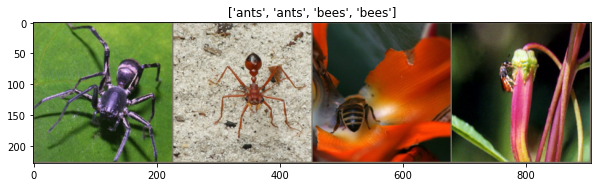

In [ ]:
inputs, labels = next(iter(dataloaders['train']))
grid_images = torchvision.utils.make_grid(inputs)

def no_normalize(im):
    im = im.permute(1, 2, 0)
    im = im*torch.Tensor([0.229, 0.224, 0.225])+torch.Tensor([0.485, 0.456, 0.406])
    return im


grid_images = no_normalize(grid_images)
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in labels])
plt.imshow(grid_images)

plt.show()

### Use Pre-trained Model :

In [ ]:
from torchvision import models

# GoogleNet
model = models.googlenet(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
for n, m in model.named_modules():
     m.auto_name = n
     print(n)


conv1
conv1.conv
conv1.bn
maxpool1
conv2
conv2.conv
conv2.bn
conv3
conv3.conv
conv3.bn
maxpool2
inception3a
inception3a.branch1
inception3a.branch1.conv
inception3a.branch1.bn
inception3a.branch2
inception3a.branch2.0
inception3a.branch2.0.conv
inception3a.branch2.0.bn
inception3a.branch2.1
inception3a.branch2.1.conv
inception3a.branch2.1.bn
inception3a.branch3
inception3a.branch3.0
inception3a.branch3.0.conv
inception3a.branch3.0.bn
inception3a.branch3.1
inception3a.branch3.1.conv
inception3a.branch3.1.bn
inception3a.branch4
inception3a.branch4.0
inception3a.branch4.1
inception3a.branch4.1.conv
inception3a.branch4.1.bn
inception3b
inception3b.branch1
inception3b.branch1.conv
inception3b.branch1.bn
inception3b.branch2
inception3b.branch2.0
inception3b.branch2.0.conv
inception3b.branch2.0.bn
inception3b.branch2.1
inception3b.branch2.1.conv
inception3b.branch2.1.bn
inception3b.branch3
inception3b.branch3.0
inception3b.branch3.0.conv
inception3b.branch3.0.bn
inception3b.branch3.1
incepti

In [ ]:
model.fc

Linear(in_features=1024, out_features=2, bias=True)

In [ ]:
# Change the Last Layer, classifier[6]
# Output Features 1000 -> 2
model.fc = torch.nn.Linear(in_features=1024, out_features=2)
print('Done')

Done


### Specify Layers for Parameter Updates

In [ ]:
# Create list
params_to_update = []

update_params_name = ['fc.weight', 'fc.bias']

# 마지막 layer에 대해서만 파라미터 변경
# 마지막 layer에 대해서만 파라미터 업데이트 함 (transfer learning)
for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False


fc.weight
fc.bias


In [ ]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params_to_update, lr=0.0005)

In [ ]:
n_total_steps = len(image_datasets['train'])
n_iterations = -(-n_total_steps // 4) # ceiling division
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

def test(net, dataloader):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total
    print(f'Val Accuracy: {acc:.2f}')
    net.train()
    return round(acc, 2)

def train(net, dataloader, test_dataloader, optimizer, criterion):
    since = time.time() # start time

    num_epochs = 3
    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            freq = 5
            if ((i+1) % freq) == 0:
                print(f'Epoch {epoch + 1} Iteration {i + 1}/{n_iterations} Train Loss: {(running_loss / freq):.4f}')
                running_acc = test(net, test_dataloader)
                if (running_acc >= 97.75): # stop when 97.75% accuracy is reached
                  break
                running_loss = 0.0

    time_elapsed = time.time() - since
    print(f'Finished Training {time_elapsed}')

Total steps: 244
Iterations per epoch: 61


In [ ]:
len(dataloaders['train'])

61

In [ ]:
train(model, dataloaders['train'], dataloaders['val'], optimizer, criterion)

Epoch 1 Iteration 5/61 Train Loss: 0.4285
Val Accuracy: 93.46
Epoch 1 Iteration 10/61 Train Loss: 0.3557
Val Accuracy: 92.16
Epoch 1 Iteration 15/61 Train Loss: 0.2903
Val Accuracy: 92.81
Epoch 1 Iteration 20/61 Train Loss: 0.3236
Val Accuracy: 90.85
Epoch 1 Iteration 25/61 Train Loss: 0.5013
Val Accuracy: 90.20
Epoch 1 Iteration 30/61 Train Loss: 0.4260
Val Accuracy: 92.81
Epoch 1 Iteration 35/61 Train Loss: 0.4590
Val Accuracy: 92.81
Epoch 1 Iteration 40/61 Train Loss: 0.3056
Val Accuracy: 92.81
Epoch 1 Iteration 45/61 Train Loss: 0.2842
Val Accuracy: 92.81
Epoch 1 Iteration 50/61 Train Loss: 0.3222
Val Accuracy: 93.46
Epoch 1 Iteration 55/61 Train Loss: 0.4777
Val Accuracy: 94.12
Epoch 1 Iteration 60/61 Train Loss: 0.3227
Val Accuracy: 92.81
Epoch 2 Iteration 5/61 Train Loss: 0.4570
Val Accuracy: 92.81
Epoch 2 Iteration 10/61 Train Loss: 0.3844
Val Accuracy: 92.81
Epoch 2 Iteration 15/61 Train Loss: 0.3688
Val Accuracy: 93.46
Epoch 2 Iteration 20/61 Train Loss: 0.5603
Val Accuracy: 

### Done!